In [1]:
import os
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.stats import norm
from itertools import cycle


import torch
torch.multiprocessing.set_sharing_strategy('file_system')
from torch import nn
import torch.optim as opt
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from livelossplot import PlotLosses
from mpl_toolkits.axes_grid1 import ImageGrid
from collections import OrderedDict

from cycle_consistent_vae import Encoder, Decoder
from sprites import Sprites


np.random.bit_generator = np.random._bit_generator

In [2]:
def mse_loss(inp, target):
    return torch.sum((inp - target).pow(2)) / inp.data.nelement()


def l1_loss(inp, target):
    return torch.sum(torch.abs(inp - target)) / inp.data.nelement()

def reparameterize(training, mu, logvar):
    if training:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    else:
        return mu

def weights_init(layer):
    if isinstance(layer, nn.Conv2d):
        layer.weight.data.normal_(0.0, 0.05)
        layer.bias.data.zero_()
    elif isinstance(layer, nn.BatchNorm2d):
        layer.weight.data.normal_(1.0, 0.02)
        layer.bias.data.zero_()
    elif isinstance(layer, nn.Linear):
        layer.weight.data.normal_(0.0, 0.05)
        layer.bias.data.zero_()

def kl_divergence_loss(mu, logvar):
    loss = 3 * (- 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))
    
    return loss / (BATCH_SIZE * 3 * 60 * 60)

def imshow_grid(images, shape=[8, 8], name='default', save=False):
    """
    Plot images in a grid of a given shape.
    Initial code from: https://github.com/pumpikano/tf-dann/blob/master/utils.py
    """
    fig = plt.figure(1)
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)

    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.

    if save:
        plt.savefig('./test_images/' + str(name) + '.png')
        plt.clf()
    else:
        plt.show()

In [3]:
BATCH_SIZE = 64

In [4]:
train_data = Sprites()
test_data = Sprites(split='test')

In [5]:
train_loader = cycle(DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2, drop_last=True))
test_loader = cycle(DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2, drop_last=True))

In [6]:
TIME_STAMP = time.strftime("%d%m%Y-%H%M%S")

NUM_EPOCHS = 6
# logging.info("NUM_EPOCHS - "+ str(NUM_EPOCHS))

LEARNING_RATE = 0.0001
# logging.info("LEARNING_RATE - "+ str(LEARNING_RATE))

CUDA = True

cuda = 1
device = torch.device("cuda:{}".format(cuda) if torch.cuda.is_available() else "cpu")

name = "cycle_vae_test_run"
liveloss = PlotLosses(fig_path='./figures/'+name+".png")

In [7]:
Z_DIM = 16 #Style Dimension (Unspecified)
S_DIM = 16 # Class Dimension (Specified)

In [8]:
encoder = Encoder(style_dim=Z_DIM, class_dim=S_DIM)
encoder.apply(weights_init)
encoder.to(device)

decoder = Decoder(style_dim=Z_DIM, class_dim=S_DIM)
decoder.apply(weights_init)
decoder.to(device)

cross_entropy_loss = nn.CrossEntropyLoss()

# optimizer and scheduler definition
auto_encoder_optimizer = opt.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=LEARNING_RATE,
    betas=(0.9,0.999)
)

reverse_cycle_optimizer = opt.Adam(
    list(encoder.parameters()),
    lr=LEARNING_RATE,
    betas=(0.9,0.999)
)

# divide the learning rate by a factor of 10 after 80 epochs
auto_encoder_scheduler = opt.lr_scheduler.StepLR(auto_encoder_optimizer, step_size=80, gamma=0.1)
reverse_cycle_scheduler = opt.lr_scheduler.StepLR(reverse_cycle_optimizer, step_size=80, gamma=0.1)

normal_sampler = torch.distributions.normal.Normal(0.0, 1.0)

<Figure size 432x288 with 0 Axes>

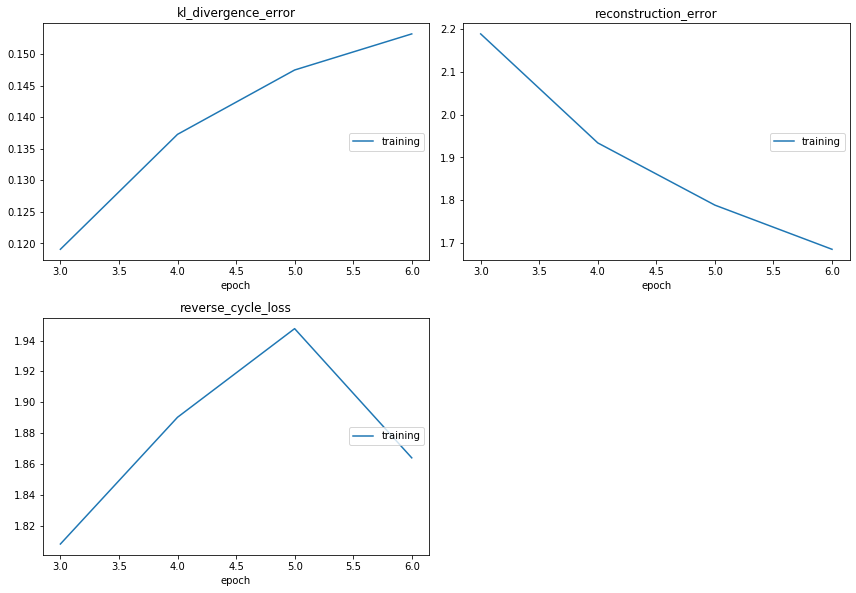

kl_divergence_error:
training   (min:    0.043, max:    0.153, cur:    0.153)

reconstruction_error:
training   (min:    1.685, max:    5.608, cur:    1.685)

reverse_cycle_loss:
training   (min:    1.560, max:    2.911, cur:    1.864)


In [9]:
for epoch in range(0,NUM_EPOCHS):
    logs = {}
    t_start = time.time()
    
    running_kl_divergence_error = 0
    running_reconstruction_error = 0
    running_reverse_cycle_loss = 0
    
    print('Epoch -', epoch)
    
    for iteration in range(int(len(train_data) / BATCH_SIZE)):
    
        """
        Training the Forward Cycle
        """
        print("Training forward cycle")
        
        auto_encoder_optimizer.zero_grad()

        elem = next(train_loader)
        image_batch_1 = elem['img1'].to(device)
        image_batch_1 = torch.transpose(image_batch_1, 2,3)
        image_batch_1 = torch.transpose(image_batch_1, 1,2)

        image_batch_2 = elem['img2'].to(device)
        image_batch_2 = torch.transpose(image_batch_2, 2,3)
        image_batch_2 = torch.transpose(image_batch_2, 1,2)



        z_mu_1, z_logvar_1, s_1 = encoder(image_batch_1)
        z_1 = reparameterize(training=True, mu=z_mu_1, logvar=z_logvar_1)

        kl_divergence_loss_1 = kl_divergence_loss(z_mu_1, z_logvar_1)
        kl_divergence_loss_1.backward(retain_graph=True)

        z_mu_2, z_logvar_2, s_2 = encoder(image_batch_2)
        z_2 = reparameterize(training=True, mu=z_mu_2, logvar=z_logvar_2)

        kl_divergence_loss_2 = kl_divergence_loss(z_mu_2, z_logvar_2)
        kl_divergence_loss_2.backward(retain_graph=True)


        recons_1 = decoder(z_1, s_2)
        recons_2 = decoder(z_2, s_1)


        recons_error_1 = 2 * mse_loss(recons_1, image_batch_1)
        recons_error_1.backward(retain_graph=True)

        recons_error_2 = 2 * mse_loss(recons_2, image_batch_2)
        recons_error_2.backward(retain_graph=True)


        kl_divergence_error = (kl_divergence_loss_1 + kl_divergence_loss_2) / 3
        reconstruction_error = (recons_error_1 + recons_error_2) / 2
        
        running_kl_divergence_error += kl_divergence_error.detach() * BATCH_SIZE
        running_reconstruction_error += reconstruction_error.detach() * BATCH_SIZE

        auto_encoder_optimizer.step()

        """
        Training the Reverse Cycle
        """
        print("Training reverse cycle")

        reverse_cycle_optimizer.zero_grad()

        elem1 = next(train_loader)
        elem2 = next(train_loader)

        image_batch_1 = elem1['img1'].to(device)
        image_batch_1 = torch.transpose(image_batch_1, 2,3)
        image_batch_1 = torch.transpose(image_batch_1, 1,2)

        image_batch_2 = elem2['img1'].to(device)
        image_batch_2 = torch.transpose(image_batch_2, 2,3)
        image_batch_2 = torch.transpose(image_batch_2, 1,2)

        z = normal_sampler.sample(sample_shape=(BATCH_SIZE,Z_DIM))

        _, _, s_1 = encoder(image_batch_1)
        _, _, s_2 = encoder(image_batch_2)

        recons_1 = decoder(z.to(device), s_1.to(device))
        recons_2 = decoder(z.to(device), s_2.to(device))

        z_mu_1, z_logvar_1, _ = encoder(recons_1)
        z_1 = reparameterize(training=False, mu=z_mu_1, logvar=z_logvar_1)

        z_mu_2, z_logvar_2, _ = encoder(recons_2)
        z_2 = reparameterize(training=False, mu=z_mu_2, logvar=z_logvar_2)

        reverse_cycle_loss = 10 * l1_loss(z_1, z_2)
        reverse_cycle_loss.backward()
        reverse_cycle_loss /= 10

        reverse_cycle_optimizer.step()
        
        running_reverse_cycle_loss+=reverse_cycle_loss * BATCH_SIZE
        
        print("Training done")



    logs['kl_divergence_error'] = running_kl_divergence_error / (iteration+1)
    logs['reconstruction_error'] = running_reconstruction_error / (iteration+1)
    logs['reverse_cycle_loss'] = running_reverse_cycle_loss / (iteration+1)
        
    if (epoch) % 5 == 0 or (epoch + 1) == 100:
        
        torch.save({'epoch': epoch,'encoder': encoder.state_dict(),'decoder': decoder.state_dict(),\
                    'kl_divergence_error': logs['kl_divergence_error'], \
                    'reconstruction_error': logs['reconstruction_error'],\
                    'reverse_cycle_loss': logs['reverse_cycle_loss']}, \
                   "./models/"+name+"_"+TIME_STAMP+"_"+str(epoch)+".pth")


        """
        save reconstructed images and style swapped image generations to check progress
        """
        elem1 = next(train_loader)
        image_batch_1 = elem1['img1'].to(device)
        image_batch_1 = torch.transpose(image_batch_1, 2,3)
        image_batch_1 = torch.transpose(image_batch_1, 1,2)

        image_batch_2 = elem1['img2'].to(device)
        image_batch_2 = torch.transpose(image_batch_2, 2,3)
        image_batch_2 = torch.transpose(image_batch_2, 1,2)
        
        
        elem2 = next(train_loader)
        image_batch_3 = elem2['img2'].to(device)
        image_batch_3 = torch.transpose(image_batch_3, 2,3)
        image_batch_3 = torch.transpose(image_batch_3, 1,2)
  

        z_mu_1, z_logvar_1, _ = encoder(image_batch_1)
        _, __, s_2 = encoder(image_batch_2)
        z_mu_3, z_logvar_3, _ = encoder(image_batch_3)

        z_1 = reparameterize(training=False, mu=z_mu_1, logvar=z_logvar_1)
        z_3 = reparameterize(training=False, mu=z_mu_3, logvar=z_logvar_3)

        recons_1_2 = decoder(z_1, s_2)
        recons_3_2 = decoder(z_3, s_2)

        # save input image batch
        image_batch = np.transpose(image_batch_1.detach().cpu().numpy(), (0, 2, 3, 1))
        imshow_grid(image_batch, name=str(epoch) + '_original', save=True)

        # save reconstructed batch
        recons_x = np.transpose(recons_1_2.detach().cpu().numpy(), (0, 2, 3, 1))
        imshow_grid(recons_x, name=str(epoch) + '_target', save=True)

        style_batch = np.transpose(image_batch_3.detach().cpu().numpy(), (0, 2, 3, 1))
        imshow_grid(style_batch, name=str(epoch) + '_style', save=True)

        # save style swapped reconstructed batch
        recons_style = np.transpose(recons_3_2.detach().cpu().numpy(), (0, 2, 3, 1))
        imshow_grid(recons_style, name=str(epoch) + '_style_target', save=True)
    
    
    delta = time.time() - t_start
    print('Epoch time - ',delta)
    

    liveloss.update(logs)
    liveloss.draw()